#### Similar to the `compare lig_res_interactions_by_type`, the goal here is compare interactions between simulations, only here is about specific residues, not specific interactions

This used to be a same part of that script when it was a sandbox script, but I figured it would be best that this is alone now


This is going to be used to measure how interactions are between conditions (eg showing that crystal sims don't have very different fingerprints, whereas EM does)

In [23]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import prolif as plf
import MDAnalysis as mda
import pandas as pd
import seaborn as sns

sys.path.append('../')
import src.analysis_functions as analysis_functions
import src.simulation_metadata as sims
from src.figure_parameters import figure_rc_params
import matplotlib as mpl

In [24]:
sim_list = [sims.PfHT_MMV_crystal, 
            sims.PfHT_MMV8_crystal, 
            sims.W412A_MMV_crystal,
            sims.GLUT3_MMV_crystal
            ]

#sim_list = [sims.PfHT_MMV12, 
#            sims.PfHT_MMV8, 
#            sims.W412A_MMV12,
#            #sims.GLUT3_MMV_crystal
#            ]

color_l = [sim.color for sim in sim_list]

all_unis, all_lens = analysis_functions.load_unis(
    sim_list= sim_list
)


In [25]:
all_fp_dfs = {}
skip = 1

for sim in sim_list:
    temp_fp_dfs = []
    for n, rep_fp in enumerate(all_unis[sim.name]):
        df = analysis_functions.get_fp_dataframe(
            u=rep_fp,
            skip=skip,
            run_calc=False,
            filename=f"{sim.name}.replica_{n+1}.skip{skip}",
        )
        temp_fp_dfs.append(df)
    all_fp_dfs[sim.name] = temp_fp_dfs


# Calculate percentage of whatever interaction you want
Just find where t.ex TRP412 (or equivalent) is in the dataframe, then take mean

#### Pt 1 - First function `mean_intxns_per_res_wide` will output a df for one residue. You can plot this directly comparing interaction types

##### `res_map` will help with residue numbering and labeling, since it's different between PfHT and GLUTs osv

In [26]:
res_map = {"W412":{'PfHT1':'TRP391', 'GLUT1':'TRP381', 'GLUT3':'TRP386'},
           "Q169":{'PfHT1':'GLN148', 'GLUT1':'GLN154', 'GLUT3':'GLN159'},
           "Q305":{'PfHT1':"GLN284", 'GLUT3':'GLN280'},
           "Q306":{'PfHT1':"GLN285", 'GLUT3':'GLN281'},
           "N341":{'PfHT1':'ASN320', 'GLUT3':'ASN315'},
           "N311":{"PfHT1":'ASN290', 'GLUT3':'ASN286'},
           "W436":{"PfHT1":'TRP415', 'GLUT3':'TRP410'},
           "A404":{"PfHT1":'ALA383', 'GLUT3':'GLU378'},
           "S315":{"PfHT1":'SER294', 'GLUT3':'TYR290'}
           
           }

res= 'Q169'


#### then, use this function to get the mean interactions per residue. Will return a wide dataframe with the top level being protein condition, the lower level being the replica, and index being interaction type

In [27]:
def mean_intxns_per_res_wide(
        resname: str,
        all_fp_dfs: dict=all_fp_dfs,
        res_map: dict=res_map,
        sim_list: list=sim_list,
        mean_cutoff: int=0.1,
) -> pd.DataFrame:
    '''
    Will loop through the sim_list
    For each element in list, loop through all reps of this element, finding the 
    fingerprint for the given residue. This is dictated by res_map, seen in the cell above
    
    Find all intxns for this res, then combine all replicas (mean_intxn_all_reps), 
    then combine all conditions, left with a wide dataframe called mean_intxn_all_conds
    '''
    
    mean_intxn_all_conds = {}
    for sim in sim_list:
        replica_names = [f"replica {i}" for i in range(1, sim.n_replicas + 1)]

        ### group replicas as cols into a wide dataframe
        mean_intxn_all_reps = []
        for rep in all_fp_dfs[sim.name]:

            #res_map[resname][PfHT1] will return TRP391 for W412, t.ex
            # need a special case for w412
            if "W412" in sim.name and resname == 'W412':
                try:
                    mean_intxn = rep["ALA391"].mean()
                except KeyError:
                    pass ## passing is fine because will become nan later
            else:
                try:
                    mean_intxn = rep[res_map[resname][sim.protein]].mean()
                except KeyError:
                    pass
            mean_intxn = mean_intxn.loc[mean_intxn > mean_cutoff]
            mean_intxn_all_reps.append(mean_intxn)
        mean_intxn_all_reps = pd.concat(mean_intxn_all_reps, axis=1, keys=replica_names)
        
        ### then group conditions as cols into wide(r) dataframe
        mean_intxn_all_conds[sim.name] = mean_intxn_all_reps
    mean_intxn_all_conds = pd.concat(mean_intxn_all_conds, axis=1)

    return mean_intxn_all_conds

In [28]:
mean_intxn_all_conds = mean_intxns_per_res_wide(
                                                resname=res,
                                                sim_list=sim_list,
                                                all_fp_dfs=all_fp_dfs
                                            )

In [29]:
mean_intxn_all_conds

PfHT_MMV_crystal                               PfHT_MMV8_crystal  \
                   replica 1 replica 2 replica 3 replica 4         replica 1   
interaction                                                                    
Hydrophobic         0.105000       NaN       NaN  0.169195          0.324602   
HBAcceptor          0.307857  0.443196  0.673099  0.481914          0.887746   
VdWContact          0.594286  0.575531  0.885358  0.645274          0.985033   
HBDonor                  NaN       NaN  0.262202       NaN               NaN   

                                W412A_MMV_crystal                      \
            replica 2 replica 3         replica 1 replica 2 replica 3   
interaction                                                             
Hydrophobic  0.227311       NaN               NaN       NaN  0.842365   
HBAcceptor   0.498751  0.570358          0.210789  0.146504  0.349754   
VdWContact   0.690258  0.696087          0.304695  0.175361  0.794745   
HBDonor           NaN       NaN               NaN       NaN       NaN   

            GLUT3_MMV_crystal                      
                    replica 1 replica 2 replica 3  
interaction                                        
Hydrophobic               NaN       NaN  0.363962  
HBAcceptor                NaN       NaN  0.948687  
VdWContact                NaN       NaN  0.996420  
HBDonor                   NaN       NaN       NaN

Since we want the order of the bar graphs to be the same, and contain same info, reindex on `intxn_index`
- This will therefore automatically keep this order, and drop other interactions I don't care about, like Hydrophobic
- Do `fillna` after to make all `nan` zero, so they appear on the bar graph as zeros

In [30]:
intxn_index = {'HBAcceptor':[], 'HBDonor':[], 'VdWContact':[], 'PiStacking':[]}
mean_intxn_all_conds = mean_intxn_all_conds.reindex(intxn_index).fillna(0)
mean_intxn_all_conds

PfHT_MMV_crystal                               PfHT_MMV8_crystal  \
                   replica 1 replica 2 replica 3 replica 4         replica 1   
interaction                                                                    
HBAcceptor          0.307857  0.443196  0.673099  0.481914          0.887746   
HBDonor             0.000000  0.000000  0.262202  0.000000          0.000000   
VdWContact          0.594286  0.575531  0.885358  0.645274          0.985033   
PiStacking          0.000000  0.000000  0.000000  0.000000          0.000000   

                                W412A_MMV_crystal                      \
            replica 2 replica 3         replica 1 replica 2 replica 3   
interaction                                                             
HBAcceptor   0.498751  0.570358          0.210789  0.146504  0.349754   
HBDonor      0.000000  0.000000          0.000000  0.000000  0.000000   
VdWContact   0.690258  0.696087          0.304695  0.175361  0.794745   
PiStacking   0.000000  0.000000          0.000000  0.000000  0.000000   

            GLUT3_MMV_crystal                      
                    replica 1 replica 2 replica 3  
interaction                                        
HBAcceptor                0.0       0.0  0.948687  
HBDonor                   0.0       0.0  0.000000  
VdWContact                0.0       0.0  0.996420  
PiStacking                0.0       0.0  0.000000

#### use `analysis_functions.process_df_wide` to make this into a long form dataframe

In [31]:
mean_intxn_all_conds = analysis_functions.process_wide_df(
    df=mean_intxn_all_conds,
    index_col_name='interaction',
    index_name='interaction',
    top_level_melt_name='protein',
    lower_level_melt_name='replica'
)


#### plot in seaborn

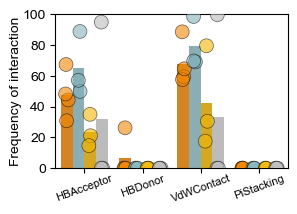

In [62]:
with mpl.rc_context(figure_rc_params):
    f,ax=plt.subplots(1,1, figsize=(3,2))
    g = sns.barplot(data=mean_intxn_all_conds,
                y='value', 
                x='interaction', 
                hue='protein',
                ax=ax,
                errorbar=None,
                palette=color_l
                )
    g.legend_.remove()

    sns.stripplot(
        data=mean_intxn_all_conds,
        y='value',
        x='interaction',
        hue='protein',
        ax=ax,
        dodge=True,
        alpha=0.6,
        edgecolor="black",
        linewidth=0.5,
        legend=False,
        size=10,
        palette=color_l
    )
    ax.set_xticks(ax.get_xticks(), 
    ax.get_xticklabels(),
    rotation=20,
    fontsize=8,
    )
    ax.tick_params(axis='x', which='major', pad=0.2)

    ax.set_xlabel(None)
    ax.set_ylim(0,1)
    ax.set_ylabel('Frequency of interaction', labelpad=0.002)

    ax.set_yticks(ax.get_yticks(), np.array(ax.get_yticks()*100).astype(int))
    plt.savefig(f'../../../images_paper/simulations/fingerprints/crystal_binding_fp.{res}.svg')